In [1]:
# Import Libraries
import pandas as pd
import numpy as np

from tqdm import tqdm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.utils import class_weight

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import seaborn as sns

import re

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.
C:\Users\eduar\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\eduar\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\eduar\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future versi

In [2]:
# Read Dataset and drop unwanted Columns
df = pd.read_csv('spam.csv', encoding = 'latin-1')
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

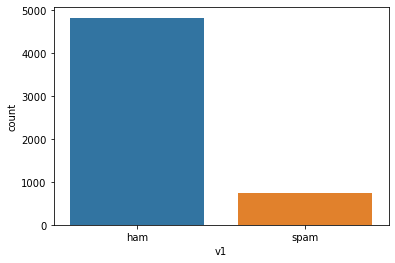

In [3]:
# Check output class distribution
ax = sns.countplot(df['v1'], label="Count")

In [4]:
# Add word count column
WordCount = []
for i in range(len(df)):
    WordCount.append(len(df['v2'][i]))
    
df['WordCount'] = WordCount

(-50.0, 300.0)

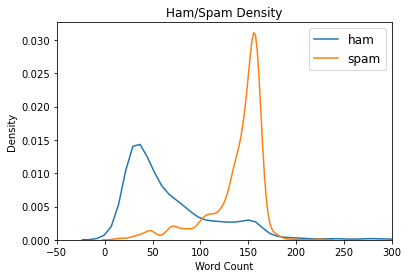

In [5]:
# Plot WordCount distribution for each class
df_plot = df[df['v1'] == 'ham']
sns.distplot(df_plot['WordCount'], hist = False, kde = True, label='ham')

df_plot = df[df['v1'] == 'spam']
sns.distplot(df_plot['WordCount'], hist = False, kde = True, label='spam')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Ham/Spam Density')
plt.xlabel('Word Count')
plt.ylabel('Density')  
plt.xlim([-50, 300])

In [6]:
# Process mensage texts
Processed = []
ps = PorterStemmer()

for i in tqdm(range(len(df))):
    msg = df['v2'][i]
    msg = msg.lower()    
    msg = msg.split()    
    msg = [ps.stem(word) for word in msg if not word in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    Processed.append(msg)

100%|█████████████████████████████████████████████████████████████████████████████| 5572/5572 [00:22<00:00, 252.58it/s]


In [7]:
# Vectorize Data
cv = CountVectorizer()
X, y = cv.fit_transform(Processed).toarray(), np.array(df['v1'].replace({'ham': 0, 'spam': 1}))
print('x.shape:', X.shape, '\ny.shape:', y.shape)

X = np.hstack((X,np.array(df['WordCount']).reshape(-1,1)))
print('x.shape:', X.shape, '\ny.shape:', y.shape)

x.shape: (5572, 8194) 
y.shape: (5572,)
x.shape: (5572, 8195) 
y.shape: (5572,)


In [8]:
# Apply DecisionTreeClassifier to predict Ham/Spam
kf = KFold(n_splits=10, shuffle = True)
kf.get_n_splits(X)

print(kf)

Metrics = []

Classifier = []

for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = tree.DecisionTreeClassifier(class_weight = 'balanced')
    clf = clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    SubMetric = dict()
    
    SubMetric['Accuracy'] = accuracy_score(y_test, y_pred)
    SubMetric['F1'] = f1_score(y_test, y_pred)
    SubMetric['Precision'] = precision_score(y_test, y_pred)
    SubMetric['Recall'] = recall_score(y_test, y_pred)
    
    Metrics.append(SubMetric)
    Classifier.append(clf)
    
Metrics = pd.DataFrame.from_dict(Metrics)

print('\n Predict test results:')
print(Metrics)

print('\n Predict test statistics:')
print(Metrics.describe([.5, .9]).transpose())

0it [00:00, ?it/s]

KFold(n_splits=10, random_state=None, shuffle=True)


10it [00:53,  5.37s/it]


 Predict test results:
   Accuracy        F1  Precision    Recall
0  0.971326  0.894737   0.894737  0.894737
1  0.960573  0.845070   0.845070  0.845070
2  0.965889  0.874172   0.825000  0.929577
3  0.967684  0.892857   0.872093  0.914634
4  0.960503  0.853333   0.853333  0.853333
5  0.951526  0.823529   0.759036  0.900000
6  0.964093  0.855072   0.819444  0.893939
7  0.965889  0.897297   0.882979  0.912088
8  0.964093  0.875000   0.864198  0.886076
9  0.969479  0.874074   0.855072  0.893939

 Predict test statistics:
           count      mean       std       min       50%       90%       max
Accuracy    10.0  0.964106  0.005616  0.951526  0.964991  0.969664  0.971326
F1          10.0  0.868514  0.024032  0.823529  0.874123  0.894993  0.897297
Precision   10.0  0.847096  0.038857  0.759036  0.854203  0.884155  0.894737
Recall      10.0  0.892339  0.026116  0.845070  0.894338  0.916128  0.929577


In [9]:
# Compute Class Weights because of unbalanced data
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)

C:\Users\eduar\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [10]:
# Apply MultiLayerPerceptron with Keras to predict Ham/Spam
kf = KFold(n_splits=10, shuffle = True)
kf.get_n_splits(X)

print(kf)

callbacks_list = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]

Metrics = []
Classifier = []

for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    model = Sequential()
    model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                        epochs = 9999,
                        validation_data = (X_test, y_test),
                        batch_size = 64,
                        callbacks = callbacks_list,
                        shuffle = True,
                        class_weight = class_weight,
                        verbose = 0)
    
    y_pred = model.predict(X_test)
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    
    SubMetric = dict()
    
    SubMetric['Accuracy'] = accuracy_score(y_test, y_pred)
    SubMetric['F1'] = f1_score(y_test, y_pred)
    SubMetric['Precision'] = precision_score(y_test, y_pred)
    SubMetric['Recall'] = recall_score(y_test, y_pred)
    
    Metrics.append(SubMetric)
    Classifier.append(clf)
    
Metrics = pd.DataFrame.from_dict(Metrics)

print('\n Predict test results:')
print(Metrics)

print('\n Predict test statistics:')
print(Metrics.describe([.5, .9]).transpose())

0it [00:00, ?it/s]

KFold(n_splits=10, random_state=None, shuffle=True)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



10it [01:43, 10.39s/it]


 Predict test results:
   Accuracy        F1  Precision    Recall
0  0.989247  0.961039   1.000000  0.925000
1  0.987455  0.950355   0.985294  0.917808
2  0.985637  0.941176   0.984615  0.901408
3  0.991023  0.964029   1.000000  0.930556
4  0.985637  0.943662   1.000000  0.893333
5  0.994614  0.980892   0.987179  0.974684
6  0.987433  0.949640   0.985075  0.916667
7  0.994614  0.976744   1.000000  0.954545
8  0.994614  0.981132   0.987342  0.975000
9  0.985637  0.946667   1.000000  0.898734

 Predict test statistics:
           count      mean       std       min       50%       90%       max
Accuracy    10.0  0.989591  0.003858  0.985637  0.988351  0.994614  0.994614
F1          10.0  0.959534  0.015556  0.941176  0.955697  0.980916  0.981132
Precision   10.0  0.992951  0.007479  0.984615  0.993671  1.000000  1.000000
Recall      10.0  0.928774  0.030000  0.893333  0.921404  0.974715  0.975000
